In [1187]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import pprint
import spacy
import matplotlib.pyplot as plt
import time
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score,classification_report
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn import cluster, datasets, preprocessing, metrics
%matplotlib inline

In [1188]:
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit']]
df=pd.read_json(subreddit_list[0])

Let's also get the nouns in the title; we can check to see to recurring nouns for 'memes'

In [1189]:
def vectorize_words(word_list):
    cvec = TfidfVectorizer()
    newtemp=pd.DataFrame()
    df_list=[]
    temp_word_list=[]
    print "Starting Word Vectorization:",time.ctime()
    
    #---
    for test in word_list[1]:
        all_words=""
        for text in test:
            all_words+=text+" "
        all_words=all_words.replace("u'","'")
        all_words=all_words.replace('\\n'," ")
        all_words=all_words.replace("\\","")
        all_words=all_words.replace("\'","")
        if len(all_words)>5:
            new_words=[word for word in all_words.split(" ") if word not in stoppers]
            new_words=[word for word in new_words]# if word not in stoppers
            temp_string=""
            for word in new_words:
                temp_string+=word+" "
        temp_word_list.append(temp_string)
    #---
    
    temp=pd.DataFrame(cvec.fit_transform(temp_word_list).todense(),columns=cvec.get_feature_names())
#     temp["Mean"]=np.mean(temp.iloc[:,:])
#     temp2=temp["Mean"].copy()
#     for col in temp.columns[:-1]:
#         temp2[col]=temp[col].copy()
#     temp.sort_values("Mean")
    print "Finished Word Vectorization:",time.ctime()
    print
    return temp

### Create the categorical variables

2 Ways:

* By predetermined categories

* By Bag of Words


aggression.csv, anarchy.json, animals.csv, art_and_literature.csv, cars.csv, conservative_terms.json, controversial_terms.json, drugs.json, eco_friendly.csv, environmental.json, feminine_terms, fitness.json, gaming.json, liberal_terms.json, marxism.json, music_and_television.csv, outdoors_words.csv, romantic_words.csv, sadness_sorry.csv, sports.json, technical_terms.json, theological.json, video_games.csv, vulgar_terms.json, weeaboo.json

# Comb through the category lists and remove any non-exclusive words and repeated words

### We read in our category lists here

In [1190]:
category_lists=["aggression.csv", "anarchy.json", "animals.csv", "art_and_literature.csv", "cars.csv", \
                "conservative_terms.json", "controversial_terms.json", "drugs.json", "eco_friendly.csv",\
                "environmental.json", "feminine_terms.csv", "fitness.json", "gaming.json", "liberal_terms.json",\
                "marxism.json", "music_and_television.csv", "outdoors_words.csv", "romantic_words.csv",\
                "sadness_sorry.csv", "sexual_terms.json", "sports.json", "technical_terms.json", \
                "theological.json", "video_games.csv", "vulgar_terms.json", "weeaboo.json"]
category_lists2=["aggression.csv", "animals.csv", "art_and_literature.csv", "cars.csv", \
                "conservative_terms.json", "controversial_terms.json", "drugs.json", "eco_friendly.csv",\
                "environmental.json", "feminine_terms.csv", "fitness.json", "gaming.json", "liberal_terms.json",\
                "marxism.json", "music_and_television.csv", "outdoors_words.csv", "romantic_words.csv",\
                "sadness_sorry.csv", "sexual_terms.json", "sports.json", "technical_terms.json", \
                "theological.json", "video_games.csv", "vulgar_terms.json", "weeaboo.json"]
base_extension="/Users/thomas/GA-DSI/projects/projects-capstone/Work 2, Personalities/Key Terms Lists/"

In [1191]:
# Here we are just reading in the category word lists into a list. Out put is a list of category lists.
i=0
category_word_list=[]
for i in range(len(category_lists)):
    extension=base_extension+category_lists[i]
    if category_lists[i][-3:]=='csv':
        df=pd.read_csv(extension)
        words=[word for word in df.iloc[:,0]]
    elif category_lists[i]=='sexual_terms.json':
        df=pd.read_json(extension)
        words=[word for word in df.iloc[:,0]]
    else:
        df=pd.read_table(extension)
        info=df.columns[0]
        info=info.strip(':').strip(',').split('\\"')
        words=[]
        for i in range(1,len(info)):
            if i%2==0:
                if len(info[i])>4:
                    words.append(info[i])
    category_word_list.append(words)
category_count=[]

### Quick function to remove duplicates from categories and non-exclusive words from categories

In [1192]:
all_words=[]
new_cat_word_list=[]
i=0
for words in category_word_list:
    new_cat_word_list.append([x.lower() for x in words])
    cat_words=pd.DataFrame(new_cat_word_list[-1]).iloc[:,0].value_counts()
    del_words=[]
    for word in range(len(cat_words)):
            # This number below will remove words from a cat_list if they occur more than 'n' times
        if cat_words[word]>1:
            if cat_words[word] not in del_words:
                del_words.append(cat_words.index[word])
    for word in del_words:
        while word in new_cat_word_list[-1]:
            new_cat_word_list[-1].remove(word)
category_word_list=new_cat_word_list
for words in category_word_list:
    all_words.extend(words)
words=pd.DataFrame(all_words).iloc[:,0].value_counts()
del_words=[]
for word in range(len(words)):
        #This number will remove words that occur across categories more than 'n' number of times
    if words[word]>1:
        del_words.append(words.index[word])
for word in del_words:
    for cat in category_word_list:
        while word in cat:
            cat.remove(word)

/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


#### Quick Function to check how many words remain after filtering

In [1193]:
sum([len(x) for x in category_word_list])

15267

### We read in our subreddit data here

In [1196]:
# Here, we are reading in our post information in the format ([post_type_list],[post_comments_list]).
# Output is a list of subreddits, which contains a list of all post information.
subreddit_names=pd.read_csv('Top Subreddits.csv')
subreddit_list=['Subreddit Data/'+x[3:]+'.json' for x in subreddit_names['Reddit'][:125]]
df=pd.read_json(subreddit_list[0])
top_post_info=[]
count=0
start_time=time.time()
for subreddit in subreddit_list:
    if count%20==0:
        print 
    if count<9:
        print "",count+1," ",
    else:
        print count+1," ",
    count+=1
    post_comments=[]
    post_types=[]
    subreddit_df=pd.read_json(subreddit)
    for post in subreddit_df.columns:
        comments=[]
        for x in re.findall(r"(u'comment': )(.*)|(\n*)(,\n\s*u'id': )",pprint.pformat(subreddit_df.loc[5,post])):
            if "u'id': u" in x[1]:
                comments.append(x[1][:-18])
            else:
                comments.append(x[1])
        post_comments.append(comments)
        post_types.append(subreddit_df.loc[3,post].split('.')[-1].split('/')[0][:3])
    top_post_info.append([post_types,post_comments])
print
print 'Took %s seconds'%(time.time()-start_time)


 1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20  
21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40  
41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60  
61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80  
81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99   100  
101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120  
121   122   123   124   125  
Took 261.582147121 seconds


### We find out post type here

In [1197]:
### We will use this later on in the clustering; we put this here because it is relevant
all_post_types=[]
for x in top_post_info:
    all_post_types.append([])
    for y in x[0]:
        if y in ['com', 'jpg', 'gif', 'png', 'htm']:
            all_post_types[-1].append(y)
        else:
            all_post_types[-1].append('com')

## This is a time consuming function; please use the precompiled pickled file

In [1198]:
# Our function will take in the subreddit data, clean the comments to get individual words, and then will 
# check all of the words in the comments of a post to create a tally of how many category words were mentioned.
# This post-category_word_count matrix will be done for every post within a subreddit. The function will then
# return the matrix of category_word_counts for each category for each post within a subreddit.

def find_subreddit_categories(word_list,curr_title):
    newtemp=pd.DataFrame()
    df_list=[]
    temp_word_list=[]
    print "Starting Word Vectorization #%s at:"%curr_title,time.ctime()
    
    #---
    for test in word_list[1]:
        new_words=[]
        all_words=""
        for text in test:
            all_words+=text+" "
        all_words=all_words.replace("u'","'")
        all_words=all_words.replace('\\n'," ")
        all_words=all_words.replace("\\","")
        all_words=all_words.replace("\'","")
        if len(all_words)>5:
            new_words=[word for word in all_words.split(" ") if word not in stoppers]
        temp_word_list.append(new_words)
    #---
    counter=0
    # temp_word_list has len 100 going into this
    category_count=[]
    for post_word_list in temp_word_list:
        counter+=1
        if counter%75==0:
            print "Running Number",counter,"of 100"
        category_count.append([])
        for category_index in range(len(category_word_list)):
            cat_count=0
            for word in category_word_list[category_index]:
                cat_count+=post_word_list.count(word)
            category_count[-1].append([])
            category_count[-1][category_index]=cat_count
    temp=pd.DataFrame(category_count)
    temp.columns=category_lists
    return temp

In [ ]:
# Here, we use the function defined above to get the category_word_count matrix for each subreddit. We put 
# those matrices into a list. That list is then pickled to save time.
i=0
category_dfs=[]
for top_posts in top_post_info:
    i+=1
    category_dfs.append(find_subreddit_categories(top_posts,i))
pickle.dump(category_dfs,open('pickled_category_dfs','wb'))

Starting Word Vectorization #1 at: Sat Dec 10 09:43:13 2016
Running Number 75 of 100
Starting Word Vectorization #2 at: Sat Dec 10 09:45:57 2016
Running Number 75 of 100
Starting Word Vectorization #3 at: Sat Dec 10 09:47:04 2016
Running Number 75 of 100
Starting Word Vectorization #4 at: Sat Dec 10 09:48:46 2016
Running Number 75 of 100
Starting Word Vectorization #5 at: Sat Dec 10 09:50:16 2016
Running Number 75 of 100
Starting Word Vectorization #6 at: Sat Dec 10 09:51:24 2016
Running Number 75 of 100
Starting Word Vectorization #7 at: Sat Dec 10 09:53:26 2016
Running Number 75 of 100
Starting Word Vectorization #8 at: Sat Dec 10 09:55:32 2016
Starting Word Vectorization #9 at: Sat Dec 10 09:56:06 2016
Running Number 75 of 100
Starting Word Vectorization #10 at: Sat Dec 10 09:57:18 2016
Running Number 75 of 100
Starting Word Vectorization #11 at: Sat Dec 10 09:58:55 2016
Running Number 75 of 100
Starting Word Vectorization #12 at: Sat Dec 10 10:00:31 2016
Starting Word Vectorization

In [83]:
pickle.load(open('pickled_category_dfs','r'))

Scale by dividing each df by it's largest number of words, and then each row by the largest number occurring among all frames after it is scaled by dividing by the frame's largest word count.

Create axes corresponding to categories and opposite categories. Drugs could be positive and sports negative on an access. Idea is to shrink down axis number.

In [56]:
subreddit_list[0]

'Subreddit Data/AskReddit.json'

In [86]:
category_dfs[75].T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
aggression.csv,56,48,76,22,78,44,33,41,33,15,...,31,70,69,9,25,80,21,38,83,102
anarchy.json,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
animals.csv,267,181,367,109,272,178,141,227,144,98,...,175,362,310,160,107,385,114,153,348,371
art_and_literature.csv,119,73,123,62,185,74,57,100,54,36,...,116,154,91,91,38,152,36,89,214,154
cars.csv,30,23,37,12,42,33,23,30,18,16,...,25,24,58,21,16,65,10,32,51,69
conservative_terms.json,2,13,1,0,5,1,0,3,2,1,...,0,5,2,2,0,4,0,2,0,5
controversial_terms.json,2,0,1,0,0,6,2,0,1,0,...,0,0,2,0,0,0,0,0,0,0
drugs.json,37,36,29,16,56,36,38,56,27,7,...,52,42,58,34,22,101,19,28,45,49
eco_friendly.csv,15,17,19,4,31,15,18,25,8,10,...,5,14,31,13,8,42,6,8,16,26
environmental.json,1,9,2,6,11,1,4,0,5,3,...,3,5,5,8,2,4,3,4,2,3


In [472]:
# We want to scale our dataframes; so lets Min_max scale each df according to its largest word, and then further scale
# each column category according to the largest count across all dfs (this will also be scaled according to the \
# largest number of words in a df)

### Mathematically, the scaling operation above equates to the columns being divided by the max count of each category
max_words_in_df=[]
max_words_in_cat={}
for col in category_dfs[0].columns:
    max_words_in_cat[col]=0
for df in category_dfs:
    curr_max_words=0
    max_col=max(df[col])
    for col in df:
# First, find maximum word count for each category across all dfs
        if max_col>max_words_in_cat[col]:
            max_words_in_cat[col]=max(df[col])
# Then, find maximum number of words in each df
        if max_col>curr_max_words:
            curr_max_words=max_col
    max_words_in_df.append(curr_max_words)


# Then, scale the dfs in a fresh dataframe object.
scaled_dfs=[]
for i in range(len(category_dfs)):
    temp_df=category_dfs[i].copy()
    for col in temp_df:
        temp_df[col]=temp_df[col]/float(max_words_in_cat[col])
    scaled_dfs.append(temp_df)
# As it turns out, there are no anarchy words across any data_frame. We can remove this column
# If we wanted to keey this columns, we would just change the default dictionary starting value to '1'
for i in range(len(scaled_dfs)):
    del scaled_dfs[i]['anarchy.json']

In [473]:
scaled_dfs[0].T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
aggression.csv,0.343413,0.149028,0.086393,0.183585,0.663067,0.246220,0.116631,0.464363,0.356371,0.269978,...,0.399568,0.203024,0.533477,0.401728,1.000000,0.434125,0.447084,0.194384,0.086393,0.192225
animals.csv,0.339634,0.237448,0.127584,0.368576,0.560543,0.274660,0.191376,0.480213,0.466627,0.246899,...,0.571175,0.463083,0.499705,0.412286,1.000000,0.488482,0.365032,0.331955,0.101595,0.419374
art_and_literature.csv,0.544426,0.302100,0.130856,0.332795,0.896607,0.441034,0.242326,0.607431,0.415186,0.219709,...,0.578352,0.431341,0.453958,0.423263,1.000000,0.592892,0.526656,0.242326,0.085622,0.589661
cars.csv,0.552561,0.148248,0.078167,0.234501,0.525606,0.212938,0.099730,0.331536,0.517520,0.137466,...,0.485175,0.250674,0.398922,0.320755,1.000000,0.299191,0.334232,0.164420,0.037736,0.164420
conservative_terms.json,0.085106,0.148936,0.021277,0.340426,0.234043,0.170213,0.127660,0.212766,0.148936,0.063830,...,0.255319,0.170213,0.255319,0.595745,0.404255,0.106383,0.106383,0.063830,0.021277,0.255319
controversial_terms.json,0.119048,0.166667,0.023810,0.000000,0.071429,0.047619,0.071429,0.047619,0.000000,0.000000,...,0.023810,0.000000,0.071429,0.000000,0.023810,0.000000,0.047619,0.000000,0.023810,0.023810
drugs.json,0.366935,0.185484,0.060484,0.239919,0.411290,0.292339,0.131048,0.270161,0.407258,0.108871,...,0.356855,0.213710,0.252016,0.300403,0.550403,0.270161,0.348790,0.247984,0.066532,0.131048
eco_friendly.csv,0.217304,0.050302,0.026157,0.102616,0.267606,0.090543,0.066398,0.173038,0.164990,0.064386,...,0.193159,0.144869,0.227364,0.124748,1.000000,0.110664,0.122736,0.046278,0.014085,0.048290
environmental.json,0.762712,0.186441,0.135593,0.135593,0.457627,0.305085,0.152542,0.288136,0.627119,0.101695,...,0.237288,0.372881,0.203390,0.525424,0.711864,0.186441,0.186441,0.203390,0.050847,0.033898
feminine_terms.csv,0.214583,0.127083,0.070833,0.228125,0.468750,0.268750,0.142708,0.352083,0.236458,0.173958,...,0.400000,0.237500,0.254167,0.227083,1.000000,0.358333,0.332292,0.229167,0.078125,0.219792


# EDA

### Let's plot the distributions of scaled words for each category

In [138]:
# We'll begin by creating a list of all points for each category
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([x for x in df[col]])

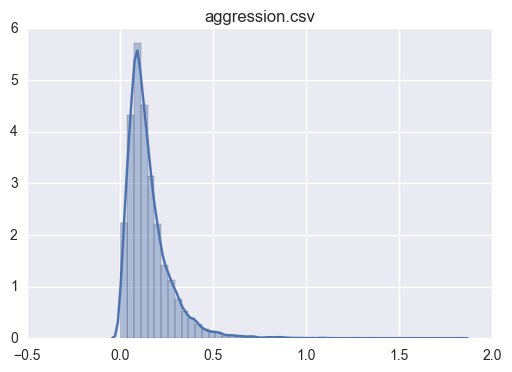

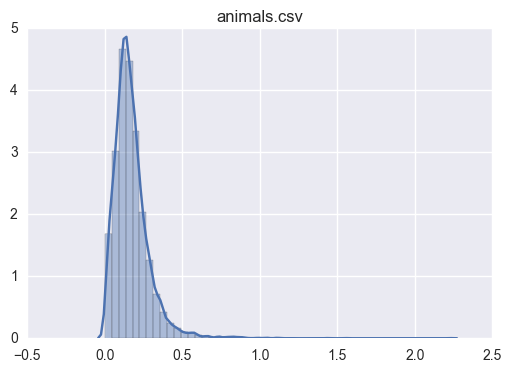

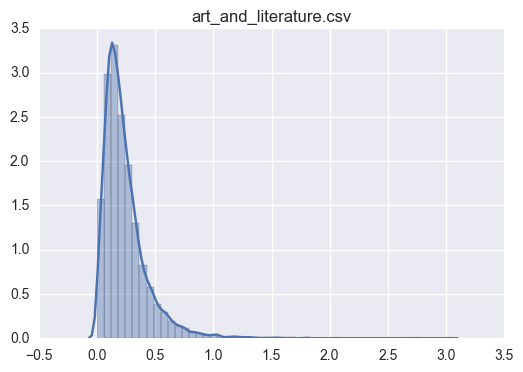

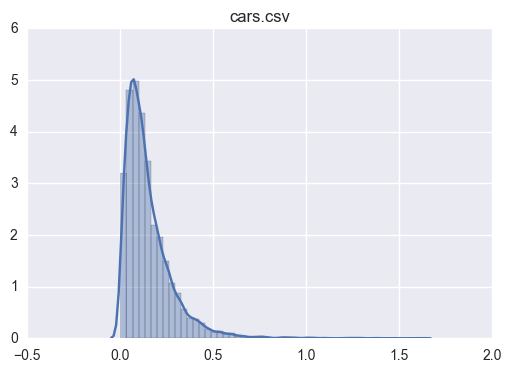

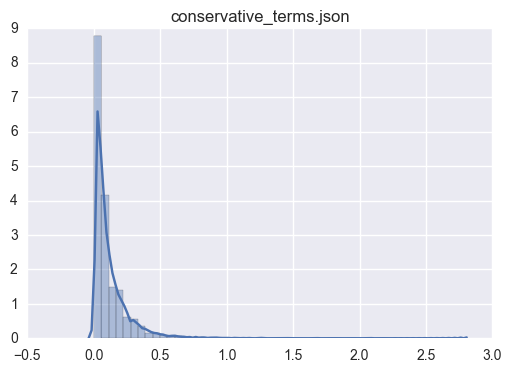

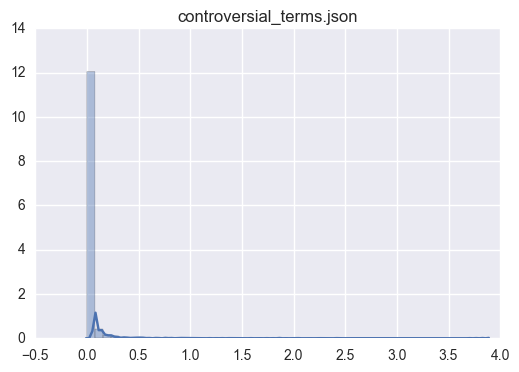

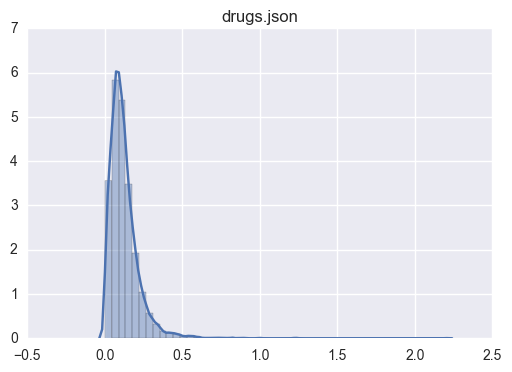

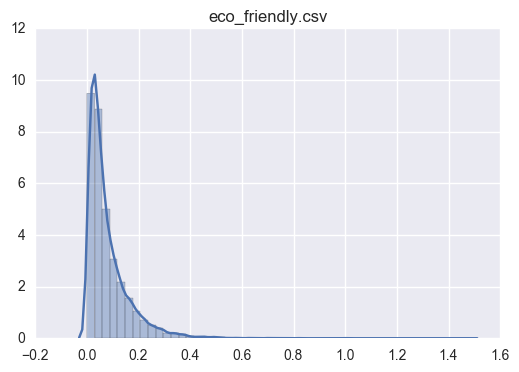

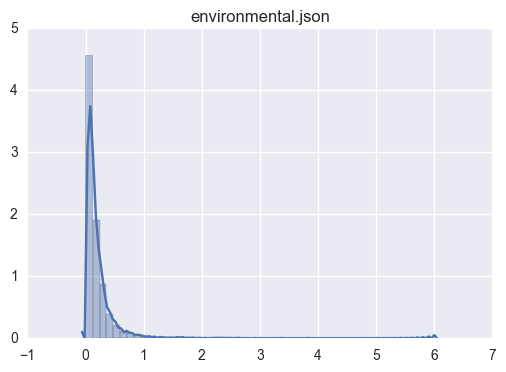

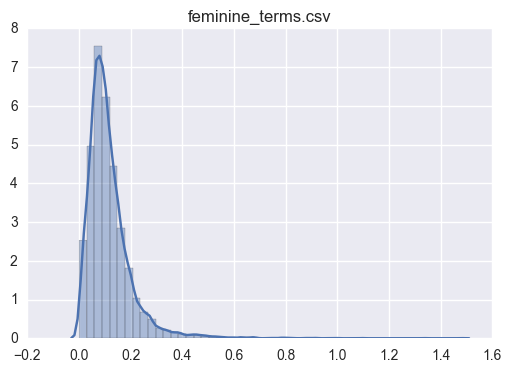

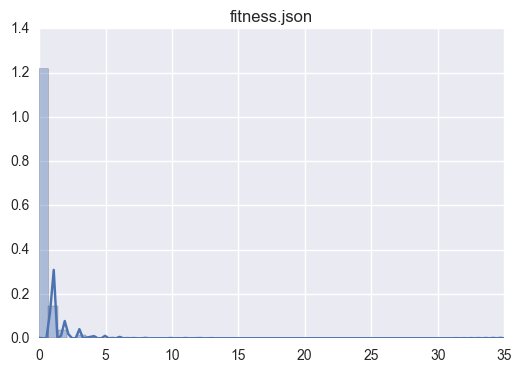

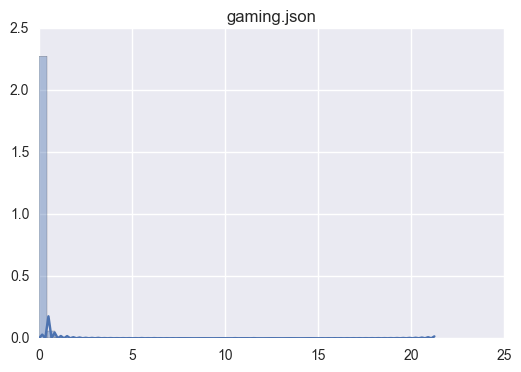

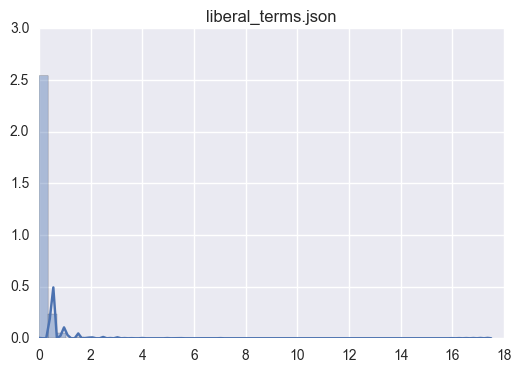

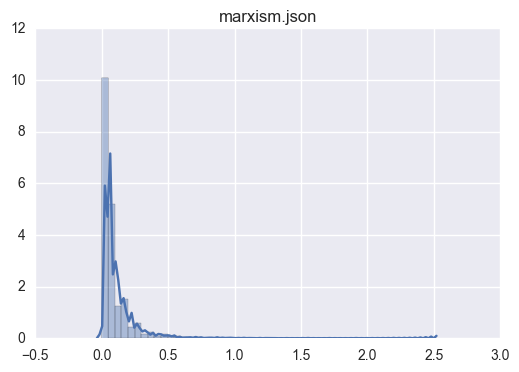

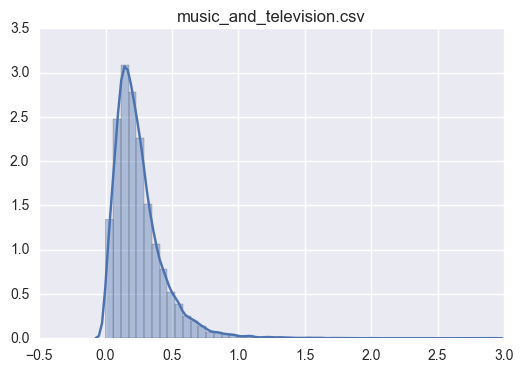

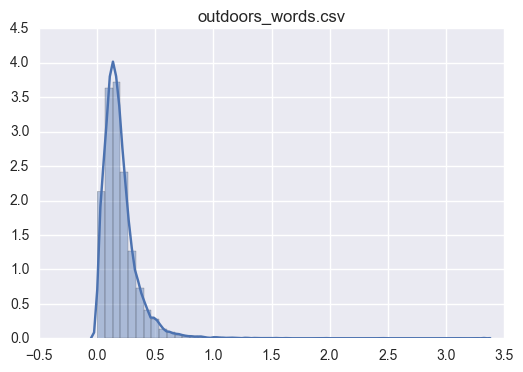

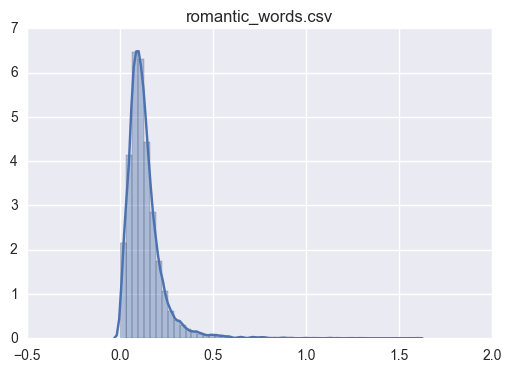

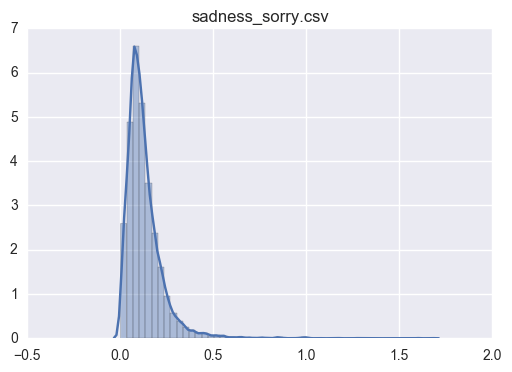

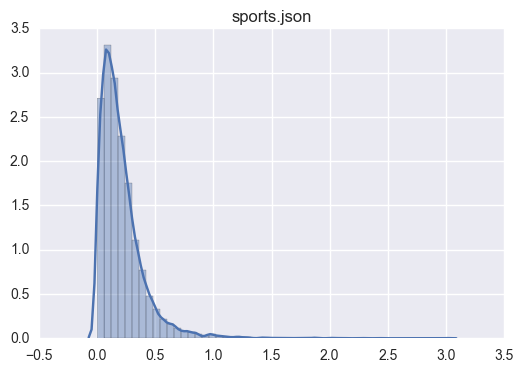

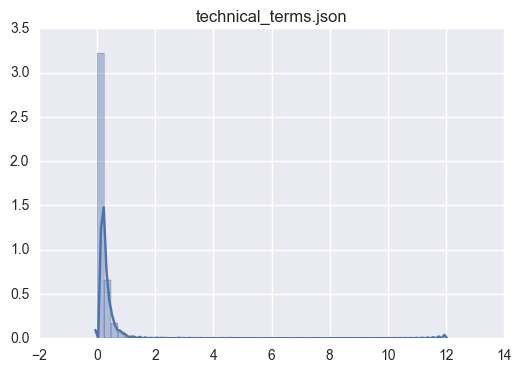

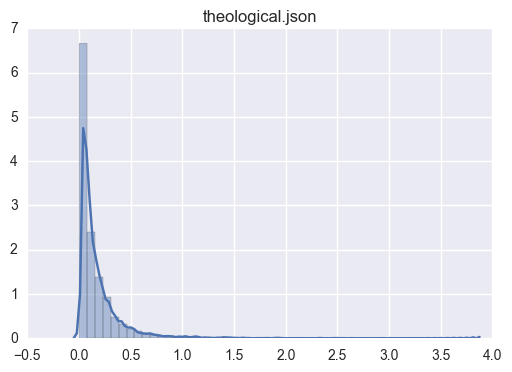

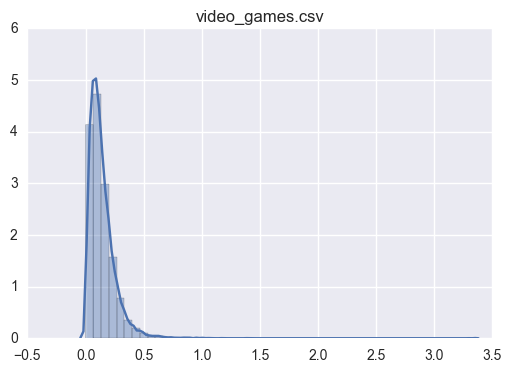

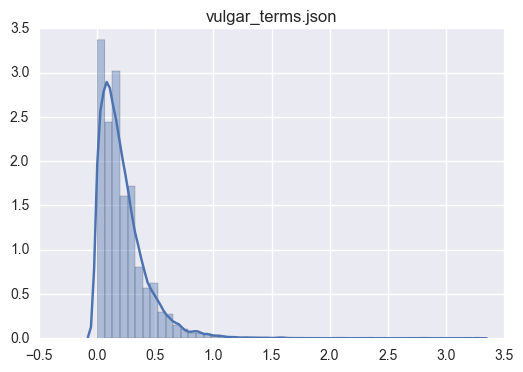

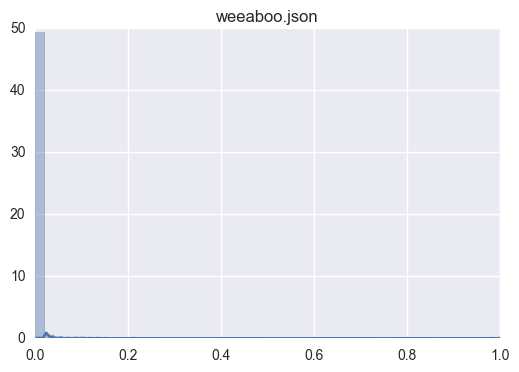

In [95]:
for category_points ,category in zip(points,scaled_dfs[0].columns):
    sns.distplot(category_points)
    plt.title(category)
    plt.show()

In [ ]:
# All of the plots are skewed normal distributions. Lets normalize the dfs now.

In [483]:
for i in range(len(points)):
    scaler=preprocessing.Normalizer()
    scaler.fit(points[i])
    for j in range(len(scaled_dfs)):
        scaled_dfs[j].iloc[:,i]=scaler.transform(scaled_dfs[j].iloc[:,i])[0]

/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

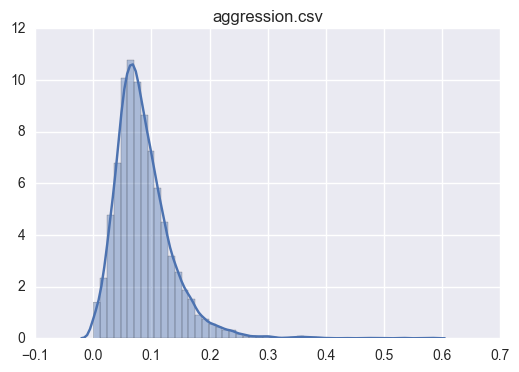

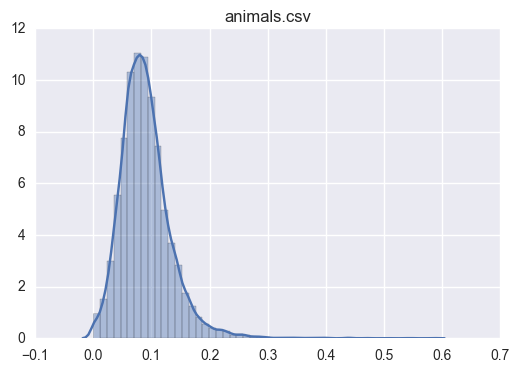

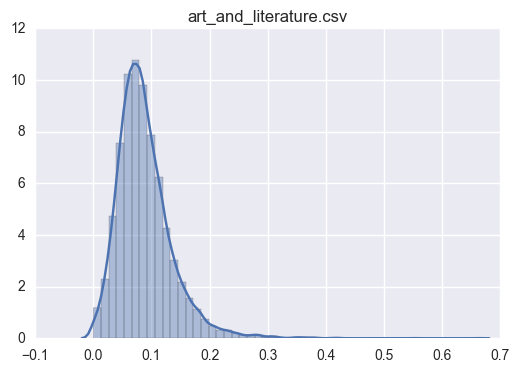

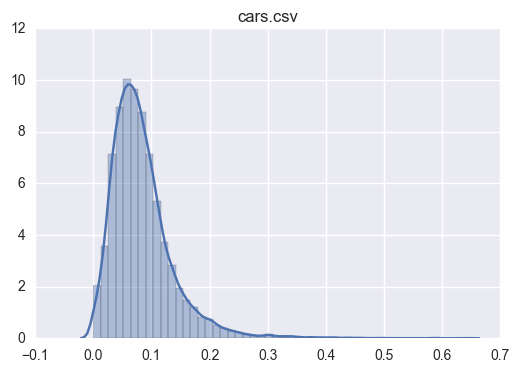

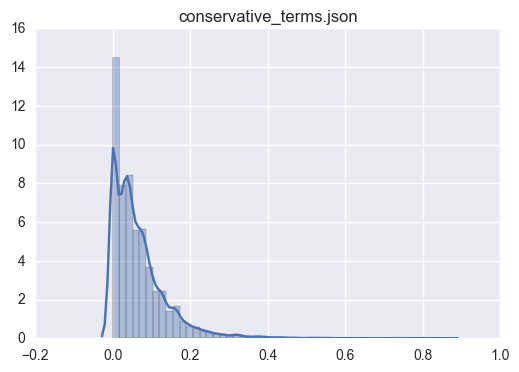

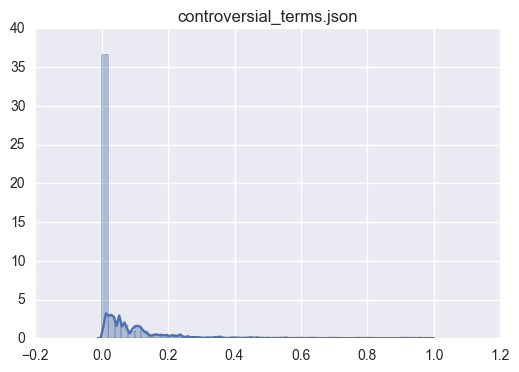

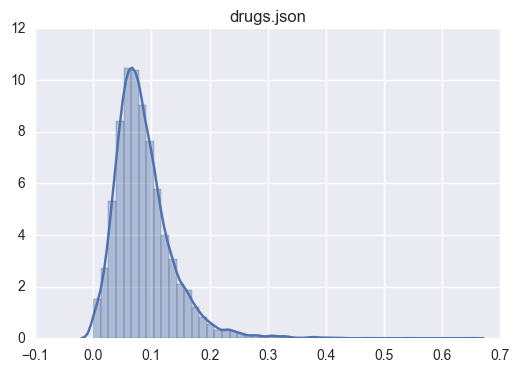

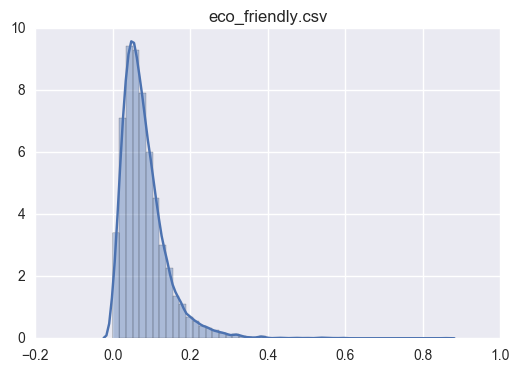

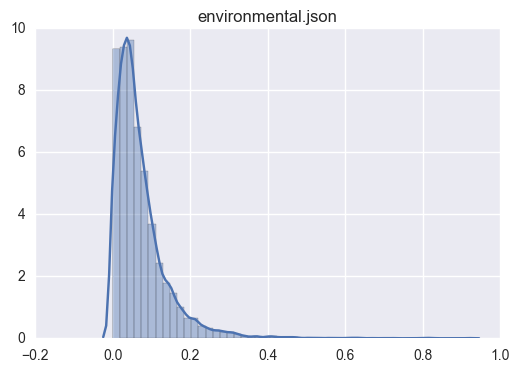

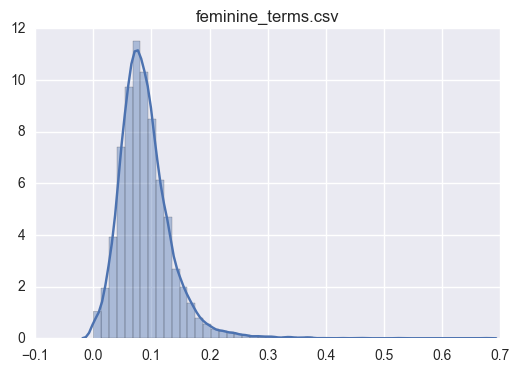

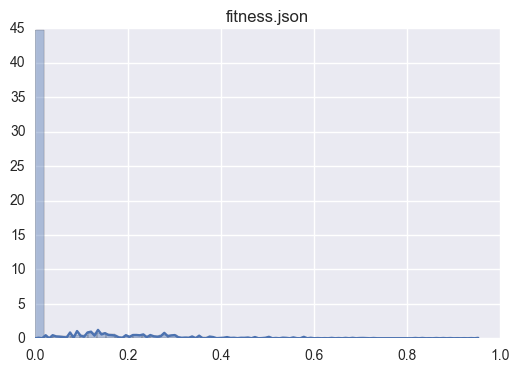

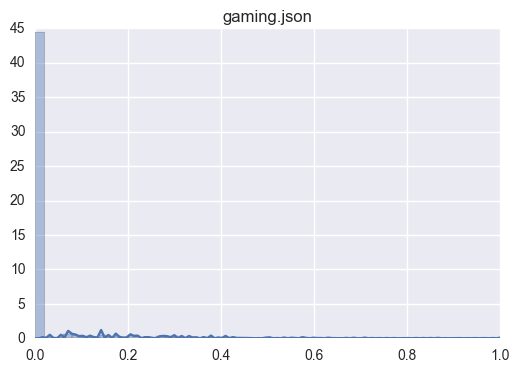

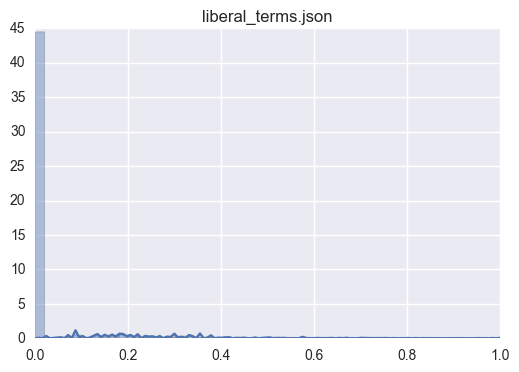

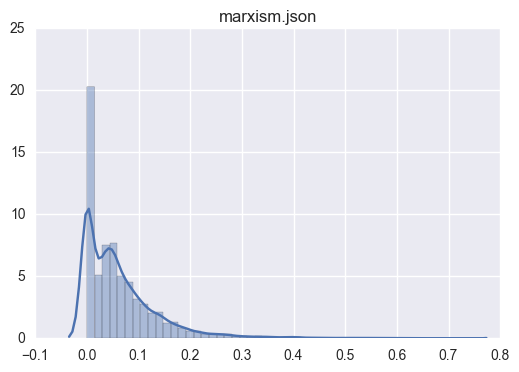

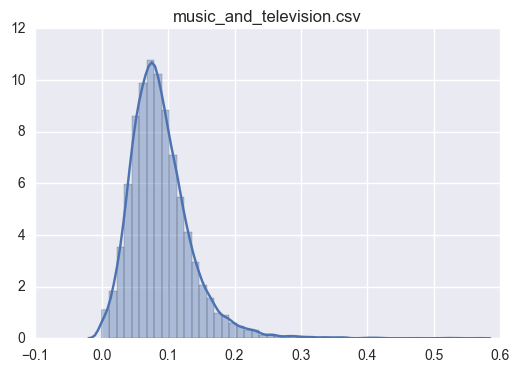

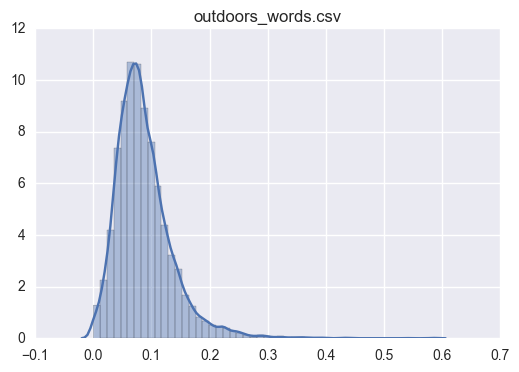

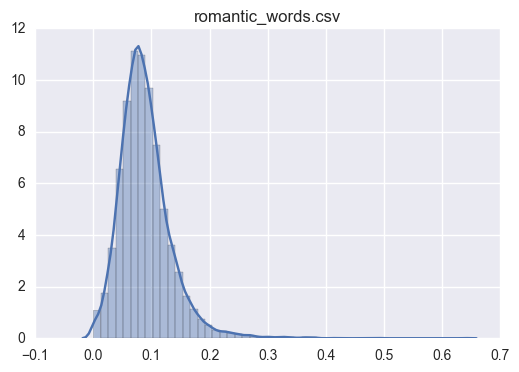

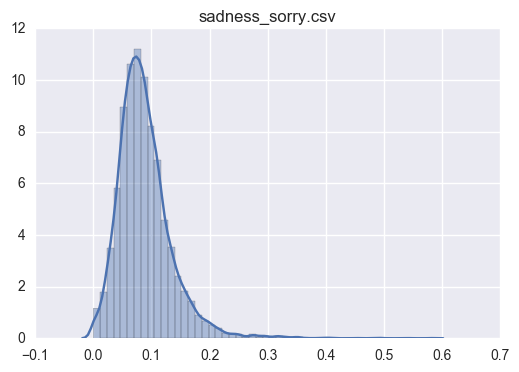

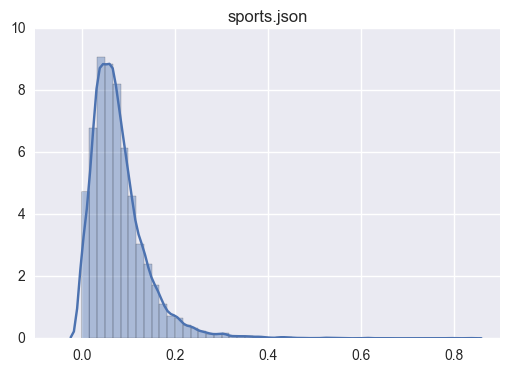

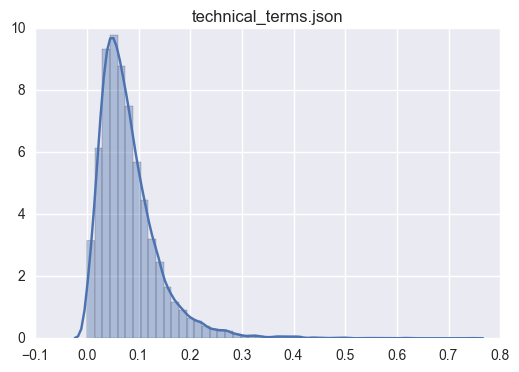

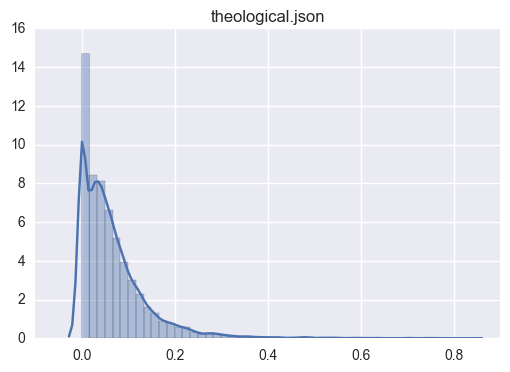

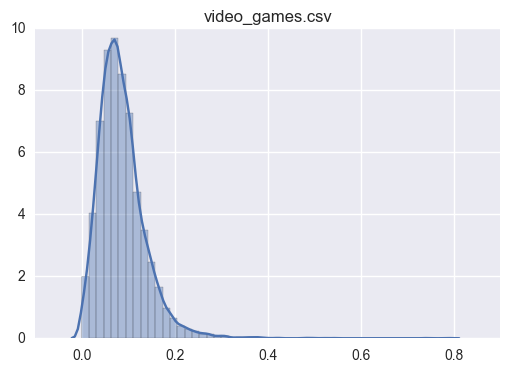

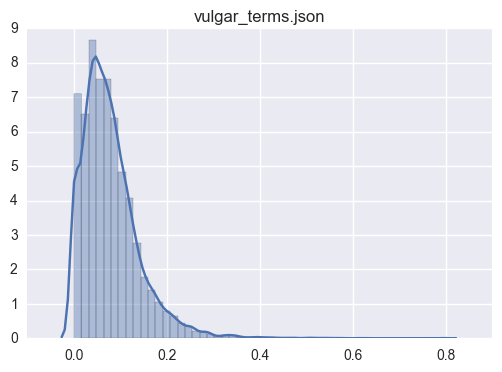

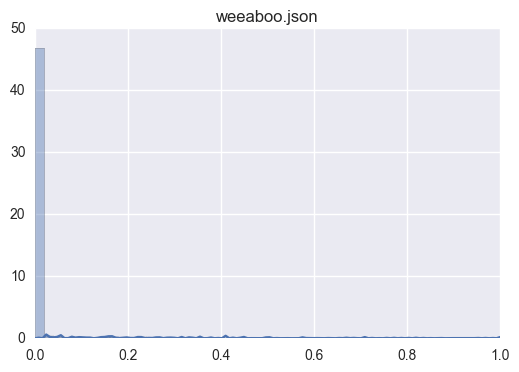

In [170]:
# Let's replot our df's with our newly scaled data
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([x for x in df[col]])
for category_points ,category in zip(points,scaled_dfs[0].columns):
    sns.distplot(category_points)
    plt.title(category)
    plt.show()

In [211]:
lists_to_use=['aggression.csv','animals.csv','art_and_literature.csv','cars.csv','drugs.json','feminine_terms.csv',\
     'marxism.json','music_and_television.csv','outdoors_words.csv','romantic_words.csv','sadness_sorry.csv',\
     'sports.json','technical_terms.json','video_games.csv','vulgar_terms.json']

In [212]:
# Find mean of each column for each df. Put it into new df. Purpose is to start clustering.
subreddit_means=[]
for df in scaled_dfs:
    subreddit_means.append([])
    for col in lists_to_use:
        subreddit_means[-1].append(np.mean(df[col]))

In [479]:
model=PCA().fit(subreddit_means)
subreddits_transformed=PCA(n_components=2).fit_transform(subreddit_means).reshape(2,-1)

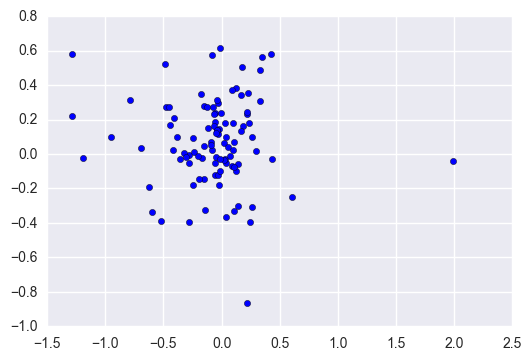

In [481]:
plt.scatter(subreddits_transformed[0],subreddits_transformed[1]);

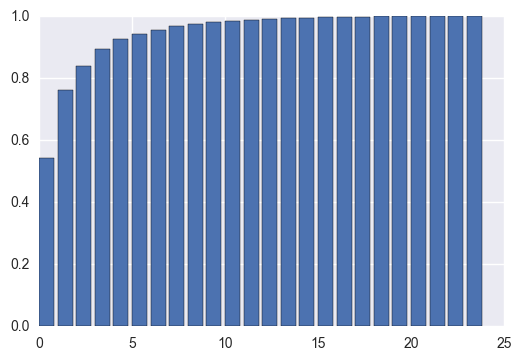

In [482]:
plt.bar(range(len(np.cumsum(model.explained_variance_ratio_))),np.cumsum(model.explained_variance_ratio_))
plt.show()

In [266]:
model=cluster.KMeans(n_clusters=12,n_init=5)
model.fit(subreddits_transformed.reshape(-1,2))
pred=model.predict(subreddits_transformed.reshape(-1,2))

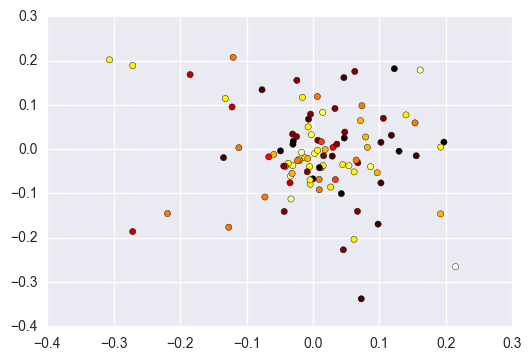

In [463]:
plt.scatter(grouped_pred[0],grouped_pred[1],c=pred,cmap='hot')

plt.show()

# Grouping

### Function for Showing Most Similar Subreddits

In [893]:
def distance_calculator(subreddit,frame):
    base_dist=frame.loc[subreddit,:]
    base_dist=base_dist[:-1]
    names=frame.index
    distances=[]
    for row in range(len(frame)):
        loc=frame.iloc[row,:-1]
        distances.append(np.sum((base_dist-loc)**2))
    points=zip(names,distances)
    points.sort(key=(lambda x:x[1]))
    return points[1:6]

### Function for coloring correlation dataframes

In [1029]:
def color(x):
    color="black"
#     x=np.abs(x)
    if x>0.2:
        color="Green"
    if x>0.3:
        color="Lime"
    if x>0.4:
        color='yellow'
    if x==0.5:
        color='white'
    if x<0.:
        color='black'
    return 'background-color: %s' %color

### Scaling

In [1030]:
# We want to scale our dataframes; so lets Min_max scale each df according to its largest word, and then further scale
# each column category according to the largest count across all dfs (this will also be scaled according to the \
# largest number of words in a df)

### Mathematically, the scaling operation above equates to the columns being divided by the max count of each category
max_words_in_df=[]
max_words_in_cat={}
for col in category_dfs[0].columns:
    max_words_in_cat[col]=0
for df in category_dfs:
    curr_max_words=0
    max_col=max(df[col])
    for col in df:
# First, find maximum word count for each category across all dfs
        if max_col>max_words_in_cat[col]:
            max_words_in_cat[col]=np.mean(df[col])
# Then, find maximum number of words in each df
        if max_col>curr_max_words:
            curr_max_words=max_col
    max_words_in_df.append(curr_max_words)


# Then, scale the dfs in a fresh dataframe object.
scaled_dfs=[]
for i in range(len(category_dfs)):
    temp_df=category_dfs[i].copy()
    for col in temp_df:
        temp_df[col]=temp_df[col]/float(max_words_in_cat[col])
    scaled_dfs.append(temp_df)
# As it turns out, there are no anarchy words across any data_frame. We can remove this column
# If we wanted to keey this columns, we would just change the default dictionary starting value to '1'
for i in range(len(scaled_dfs)):
    del scaled_dfs[i]['anarchy.json']

In [1031]:
subreddit_means=[]
for df in scaled_dfs:
    subreddit_means.append([])
    for col in df.columns:
        subreddit_means[-1].append(np.mean(df[col]))
temp_df=pd.DataFrame(subreddit_means,columns=category_lists2,index=subreddit_list)
temp1=temp_df.corr()#.style.applymap(color)
temp1=temp1-.5
temp1.style.applymap(color)

### Normalization

In [970]:
points=[]
for col in scaled_dfs[i].columns:
    points.append([])
    for df in scaled_dfs:
        points[-1].extend([x for x in df[col]])
for i in range(len(points)):
    scaler=preprocessing.Normalizer()
    scaler.fit(points[i])
    for j in range(len(scaled_dfs)):
        scaled_dfs[j].iloc[:,i]=scaler.transform(scaled_dfs[j].iloc[:,i].reshape(1, -1))[0]

/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/thomas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays 

### Assigning Importance Weighting to each list of words

In [940]:
#List of Importance Levels
ilev_1=1
ilev_2=2
ilev_3=3
ilev_4=4
ilev_5=5
ilev_6=10

list_dict={u'aggression.csv':ilev_3, 
           u'animals.csv':ilev_3, 
           u'art_and_literature.csv':ilev_6,
           u'cars.csv':ilev_3, 
           u'conservative_terms.json':ilev_3, 
           u'controversial_terms.json':ilev_4,
           u'drugs.json':ilev_6, 
           u'eco_friendly.csv':ilev_5, 
           u'environmental.json':ilev_2,
           u'feminine_terms.csv':ilev_5, 
           u'fitness.json':ilev_5, 
           u'gaming.json':ilev_3,
           u'liberal_terms.json':ilev_3,  
           u'marxism.json':ilev_3, 
           u'music_and_television.csv':ilev_4,
           u'outdoors_words.csv':ilev_5, 
           u'romantic_words.csv':ilev_2, 
           u'sadness_sorry.csv':ilev_2,
           u'sports.json':ilev_6, 
           u'technical_terms.json':ilev_6, 
           u'theological.json':ilev_1,
           u'video_games.csv':ilev_6, 
           u'vulgar_terms.json':ilev_4, 
           u'weeaboo.json':ilev_3}

for i in range(len(scaled_dfs)):
    for value in list_dict.keys():
        scaled_dfs[i][value]=scaled_dfs[i][value] * list_dict[value]

### Personality Maker

In [941]:
personality_dfs=[]

for df in scaled_dfs:
    df_p=pd.DataFrame()
    df_p['Artistic']=df['art_and_literature.csv']
    df_p["Smart"]=df['technical_terms.json']
    df_p['Gender'] =(df['animals.csv']+df['feminine_terms.csv'])/2.-(df['cars.csv']+df['aggression.csv'])/2.
    df_p['Activeness']=(df['gaming.json']+df['video_games.csv']+df['music_and_television.csv'])/3.
    df_p['Outdoors']=(df['outdoors_words.csv']+df['environmental.json']+df['outdoors_words.csv'])/3.
    df_p['Political_Orientation']=df['liberal_terms.json']-df['conservative_terms.json']
    df_p['Extremes']=df['feminine_terms.csv']
    df_p['Extremes_2']=df['marxism.json']
    df_p['Weird']=df['weeaboo.json']
    df_p['Fit']=df['fitness.json']
    df_p['Physicality']=df['drugs.json']-df['sports.json']
#     df_p['Downbeat']=df['sadness_sorry.csv']
    df_p['Emotional']=df['romantic_words.csv']
    df_p['Troll']=df['controversial_terms.json']
    df_p['Vulgarity']=df['vulgar_terms.json']
#     df_p['Religious']=df['theological.json']
    personality_dfs.append(df_p)

### Clustering

In [942]:
clus=12 # NUMBER OF CLUSTERS
comp=1 # NUMBER OF PRINCIPAL COMPONENTS
link_mod=0.1
df_list_to_use=scaled_dfs

for i in range(len(df_list_to_use)):
    link_type=all_post_types[i]
    df_list_to_use[i]["jpg"]=[link_mod if x=='jpg' else 0 for x in link_type]
    df_list_to_use[i]["gif"]=[link_mod if x=='gif' else 0 for x in link_type]
    df_list_to_use[i]["com"]=[link_mod if x=='com' else 0 for x in link_type]
    df_list_to_use[i]["png"]=[link_mod if x=='png' else 0 for x in link_type]
    df_list_to_use[i]["htm"]=[link_mod if x=='htm' else 0 for x in link_type]

# Find mean of each column for each df. Put it into new df. Purpose is to start clustering.
subreddit_means=[]
for df in df_list_to_use:
    subreddit_means.append([])
    for col in df.columns:
        subreddit_means[-1].append(np.mean(df[col]))
subreddits_transformed=PCA(n_components=comp).fit_transform(subreddit_means).reshape(comp,-1)
model=cluster.KMeans(n_clusters=clus,)
model.fit(subreddits_transformed.reshape(-1,comp))
pred=model.predict(subreddits_transformed.reshape(-1,comp))
grouped_pred=pd.DataFrame(subreddits_transformed,columns=[x[15:-5] for x in subreddit_list]).T
grouped_pred["Group"]=pred
grouped_pred=grouped_pred

In [943]:
distance_calculator('gaming',grouped_pred)

[('videos', 5.098358546417841e-08),
 ('nottheonion', 1.4817194033651747e-06),
 ('creepy', 1.3796545532471776e-05),
 ('dataisbeautiful', 2.0377816084057504e-05),
 ('food', 4.76096033525392e-05)]

In [944]:
distance_calculator('gonewild',grouped_pred)

[('pics', 1.1049306128924908e-07),
 ('science', 4.140437725115885e-06),
 ('photoshopbattles', 4.3483739225487696e-06),
 ('nba', 6.138480100757886e-06),
 ('facepalm', 1.1124755215496845e-05)]

In [945]:
for i in range(len(grouped_pred['Group'].unique())):
    print "GROUP %i" %(i+1)
    for x in grouped_pred[grouped_pred['Group']==i].index:
        print x
    print

GROUP 1
aww
gifs
space
sports
UpliftingNews
WTF
woahdude
trees
interestingasfuck
pokemongo
programming
pcmasterrace
Overwatch
cringe

GROUP 2
announcements

GROUP 3
explainlikeimfive
nsfw
RealGirls
AskHistorians

GROUP 4
blog

GROUP 5
reddit.com
pokemon

GROUP 6
science
pics
askscience
Jokes
photoshopbattles
philosophy
WritingPrompts
Fitness
bestof
gonewild
reactiongifs
malefashionadvice
Frugal
Unexpected
oddlysatisfying
HistoryPorn
nba
facepalm

GROUP 7
4chan
ImGoingToHellForThis
NSFW_GIF
relationships
YouShouldKnow
comics
tattoos

GROUP 8
news
politics

GROUP 9
todayilearned
worldnews
movies
EarthPorn
television
DIY
gadgets
Futurology
Documentaries
personalfinance
TwoXChromosomes
technology
atheism
Games
Android
cringepics

GROUP 10
AskReddit
funny
IAmA
gaming
videos
Music
books
LifeProTips
mildlyinteresting
Showerthoughts
tifu
food
history
nottheonion
dataisbeautiful
GetMotivated
OldSchoolCool
Art
creepy
AdviceAnimals
europe
gameofthrones
BlackPeopleTwitter
sex
nfl
StarWars

GROUP 1

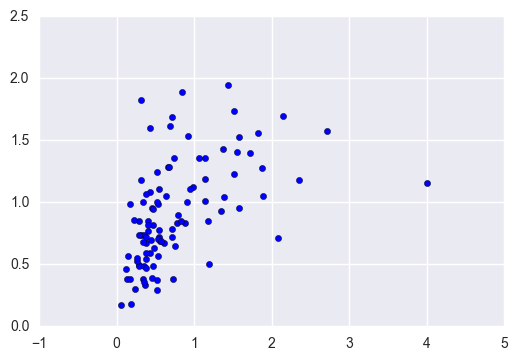

In [949]:
plt.scatter(df_p['Smart'],df_p['Artistic'])
plt.show()